In [37]:
import torch, detectron2

In [38]:
print(torch.cuda.is_available())

True


In [39]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_19:00:59_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0


In [40]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__
# print(torch.cuda.is_available())
print("torch: ", TORCH_VERSION, "; cuda: ", torch.__version__)
print("detectron2:", detectron2.__version__)

torch:  1.13 ; cuda:  1.13.1+cu117
detectron2: 0.6


In [41]:
!nvidia-smi

Sun Jan 15 23:18:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8    10W /  85W |   2107MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [42]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

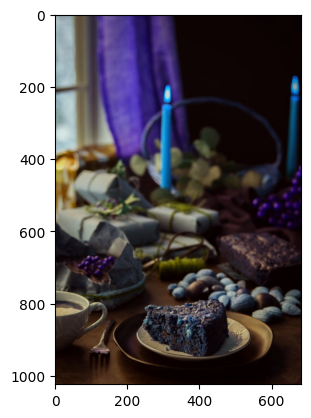

In [43]:
# im = cv2.imread("./img/1.jpeg")
# im = cv2.imread("./img/2.jpeg")
im = cv2.imread("./img/cake/c_3.jpg")

# call imshow() using plt object
plt.imshow(im)

In [44]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[01/15 23:18:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [45]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([41, 55, 55, 60, 42, 44], device='cuda:0')
Boxes(tensor([[3.2599e+00, 7.6675e+02, 1.4237e+02, 9.3119e+02],
        [2.3401e+02, 7.9229e+02, 4.9180e+02, 9.4848e+02],
        [1.8853e+01, 5.0201e+02, 2.7225e+02, 6.4496e+02],
        [5.8396e-01, 7.4936e+02, 6.7816e+02, 1.0137e+03],
        [9.4415e+01, 8.4129e+02, 1.6495e+02, 9.4559e+02],
        [8.2993e+01, 8.4105e+02, 1.6265e+02, 9.3981e+02]], device='cuda:0'))


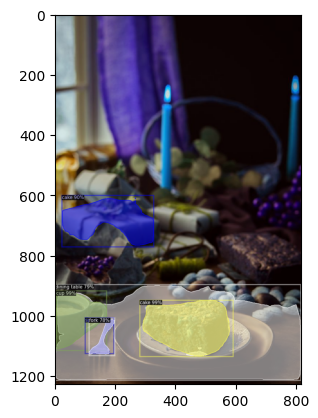

In [46]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
result_image = out.get_image()[:, :, ::-1]

plt.imshow(result_image)